In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
from scipy.stats import mode
from scipy.optimize import curve_fit
from scipy.integrate import trapz
from scipy.stats import lognorm

sys.path.append("./models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *


jax.config.update("jax_enable_x64", True)

%matplotlib inline
# plt.style.use('/home/nlinden/.matplotlib/custom.mplstyle')
plt.style.use('/Users/natetest/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *

%env CUDA_VISIBLE_DEVICES=1


env: CUDA_VISIBLE_DEVICES=1


In [2]:
def simulate_model_trajectory(model_instance, y0, params, t1=300, dt0=1e-3, n_out=1000):
    """ simulates a model over the specified time interval and returns the 
    trajectory of the model state variables."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3
    times = np.linspace(t0, t1, n_out)
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=tuple(params),
        max_steps=60000,
        throw=False,)
    
    return sol

def simulate_model_steady_state(model_instance, y0, params, t1=300, dt0=1e-3, 
    event_rtol=1e-6, event_atol=1e-6):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(params),
        max_steps=None,
        throw=True,)
    
    return sol


# Generate synthetic data using the Huang and Ferrell Model

In [3]:
# run series of simulations to generate stimulus response curves
hf_1996 = huang_ferrell_1996(transient=True)
y0_dict, y0 = hf_1996.get_initial_conditions()
p_dict, plist = hf_1996.get_nominal_params()
ss = []
ss_traj = []
E1_vals = np.logspace(-6.00, -3.75, 10, endpoint=False)
print(E1_vals)
for i, E1 in enumerate(E1_vals):
    # update params with new stimulus
    y0_dict['E1'] = E1
    y0 = tuple([y0_dict[k] for k in y0_dict.keys()])
    # run to steady-state
    sol = simulate_model_steady_state(hf_1996, y0, plist, t1=1000, event_rtol=1e-10, event_atol=1e-10)
    sol_traj = simulate_model_trajectory(hf_1996, y0, plist, t1=1000)
    ss.append(sol)
    ss_traj.append(sol_traj)

# process results
pred_mapk = np.array([s.ys[-1]+s.ys[-2] for s in ss])

[1.00000000e-06 1.67880402e-06 2.81838293e-06 4.73151259e-06
 7.94328235e-06 1.33352143e-05 2.23872114e-05 3.75837404e-05
 6.30957344e-05 1.05925373e-04]


In [4]:
print(np.log10(E1_vals))

[-6.    -5.775 -5.55  -5.325 -5.1   -4.875 -4.65  -4.425 -4.2   -3.975]


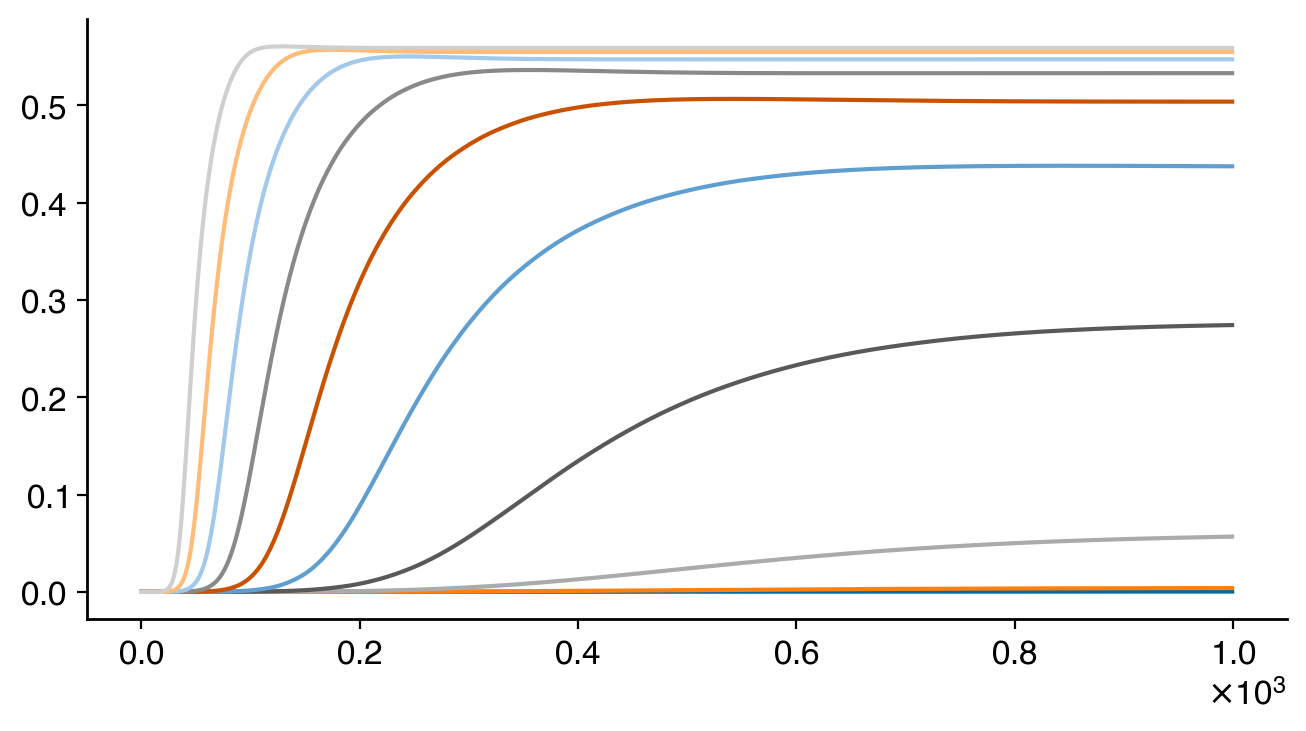

In [5]:
fig, ax = get_sized_fig_ax(6.0, 3.0)

for i in range(len(ss_traj)):
    ax.plot((ss_traj[i].ys[-1]+ss_traj[i].ys[-2]), label=f"{E1_vals[i]:.2e}")

In [13]:
# process results
erk_acts = []
for i in range(len(ss_traj)):
    erk_acts.append([ss_traj[i].ys[-1]+ss_traj[i].ys[-2]])
erk_acts = np.array(erk_acts)

np.save('../../results/MAPK/HF_96_trajs.npy', erk_acts)
np.save('../../results/MAPK/HF_96_traj_times.npy', np.linspace(0, 1000, 1000))

(10,)


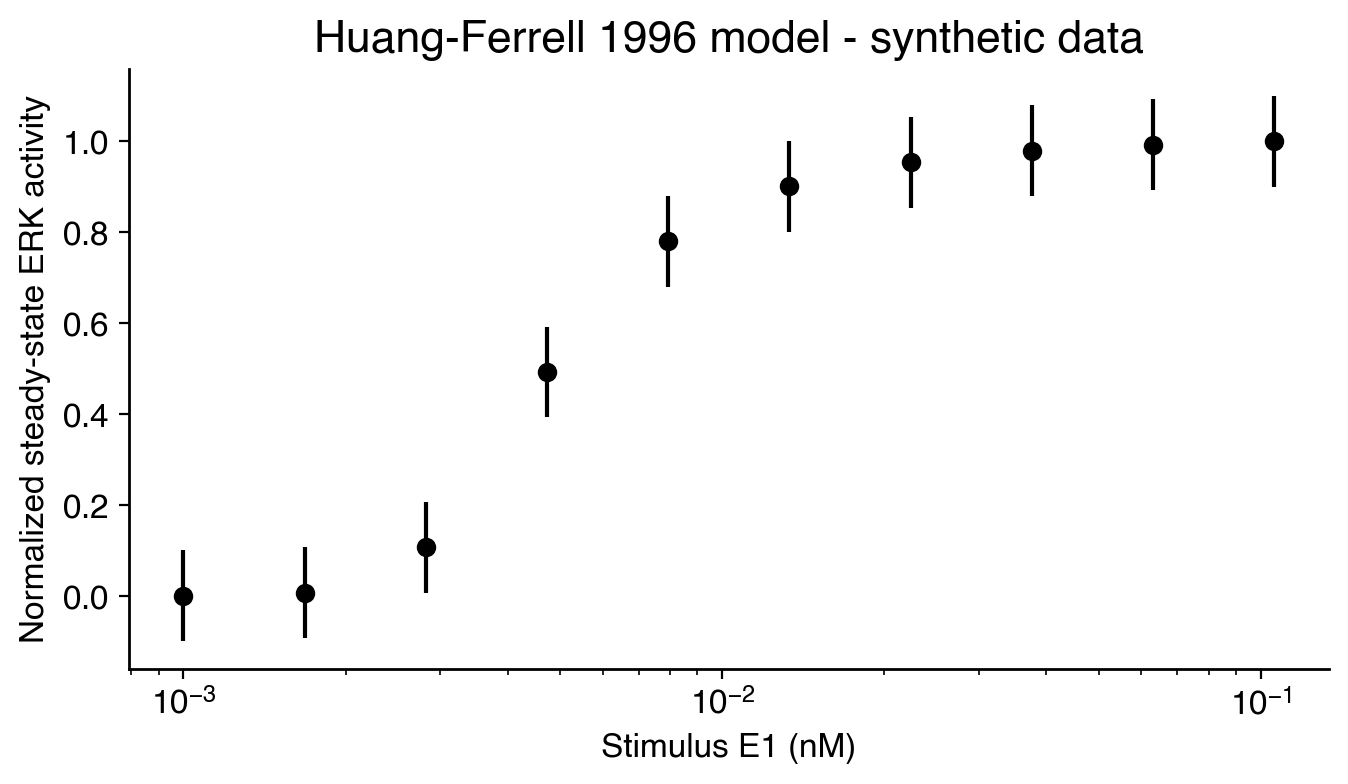

In [6]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
errors = 0.1*np.squeeze(np.ones_like(pred_mapk))
errors.shape
print(E1_vals.shape)
ax.errorbar(1000*E1_vals, np.squeeze(pred_mapk)/pred_mapk[-1], yerr=errors, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Normalized steady-state ERK activity')
ax.set_xscale('log')
ax.set_title('Huang-Ferrell 1996 model - synthetic data')
fig.savefig('../../figures/MAPK/HF_96_synthetic_data.pdf', bbox_inches='tight', transparent=True)

### Export the stimulus response curve to use for inference

In [7]:
normalized_stim_resp = np.squeeze(pred_mapk)/pred_mapk[-1]
stimulus_vals_nM = 1000*E1_vals

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/HF_96_synthetic_data.csv', index=False)

# Process data from Santos 2007

In [8]:
means = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2C.csv')
EGF_0 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0.csv')
EGF_0_001 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_001.csv')
EGF_0_01 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_01.csv')
EGF_0_1 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_1.csv')
EGF_1 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_1.csv')
EGF_3 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_3.csv')
EGF_5 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_5.csv')
EGF_10 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_1.csv')
EGF_30 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_30.csv')
EGF_50 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_50.csv')
EGF_100 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_10.csv')

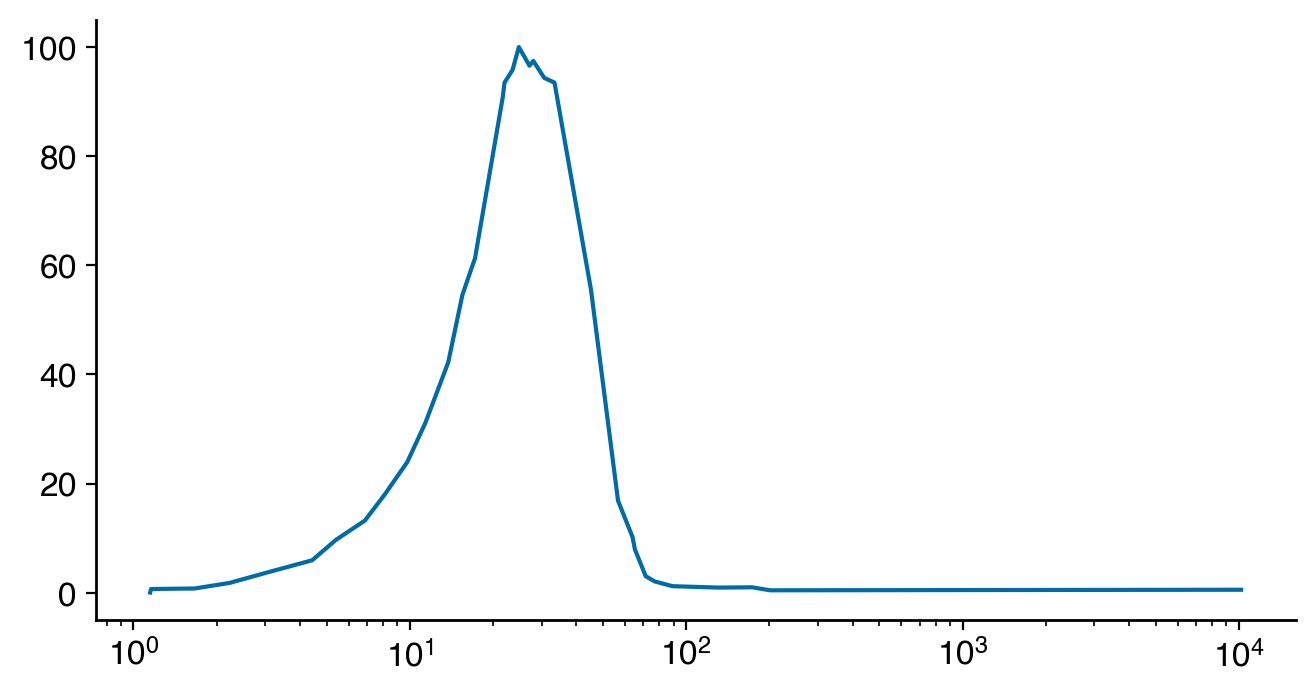

In [9]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
# ax.plot(EGF_0['x'], EGF_0[' y'], label='EGF=0')
# ax.plot(EGF_0_001['x'], EGF_001[' y'], label='EGF=0.001')
# ax.plot(EGF_0_01['x'], EGF_01[' y'], label='EGF=0.01')
# ax.plot(EGF_0_1['x'], EGF_0_1[' y'], label='EGF=0.1')
# ax.plot(EGF_1['x'], EGF_1[' y'], label='EGF=1')
# ax.plot(EGF_3['x'], EGF_3[' y'], label='EGF=3')
# ax.plot(EGF_5['x'], EGF_5[' y'], label='EGF=5')
# ax.plot(EGF_10['x'], EGF_10[' y'], label='EGF=10')
# ax.plot(EGF_30['x'], EGF_30[' y'], label='EGF=30')
# ax.plot(EGF_50['x'], EGF_50[' y'], label='EGF=50')
ax.plot(EGF_100['x'], EGF_100[' y'], label='EGF=100')
ax.set_xscale('log')

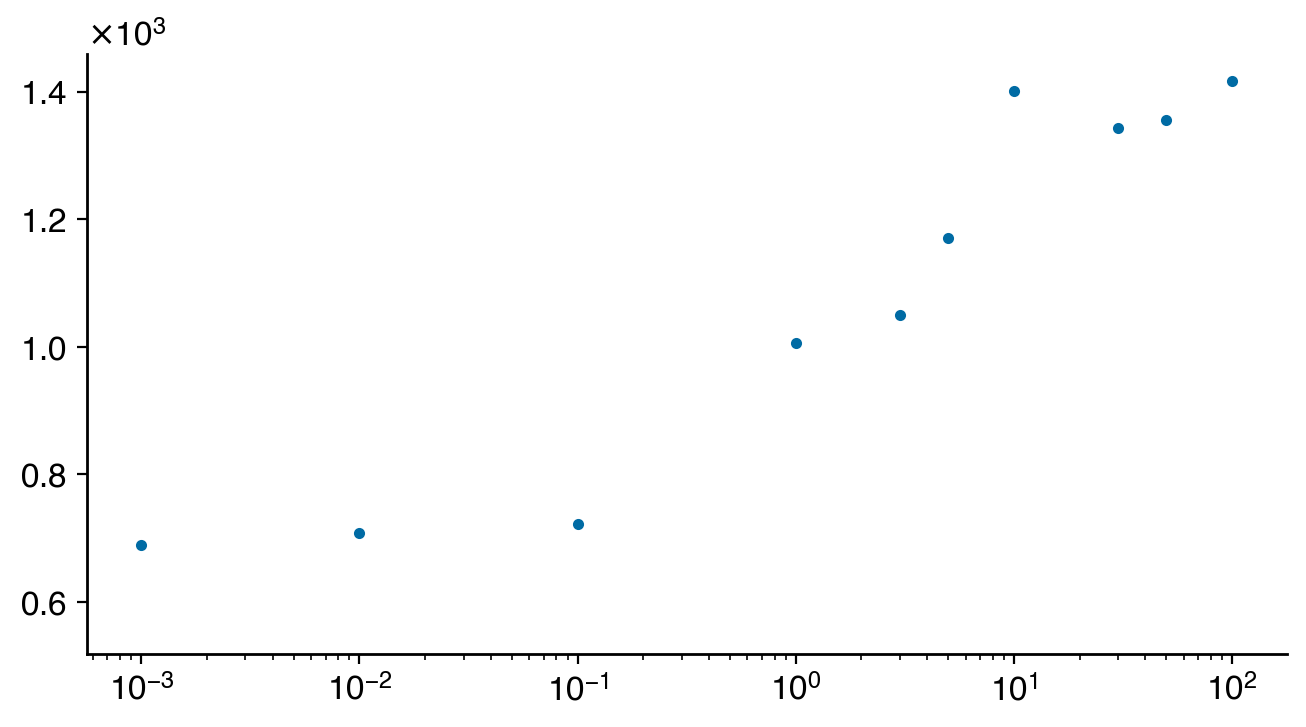

In [10]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(means['EGF (ng/ml)'], means['ppERK1/2 (a.u.)'], '.')
ax.set_xscale('log')

[3.24409302 0.48179623]
[1.65892647 0.44416554]
[2.85226081 0.51091952]


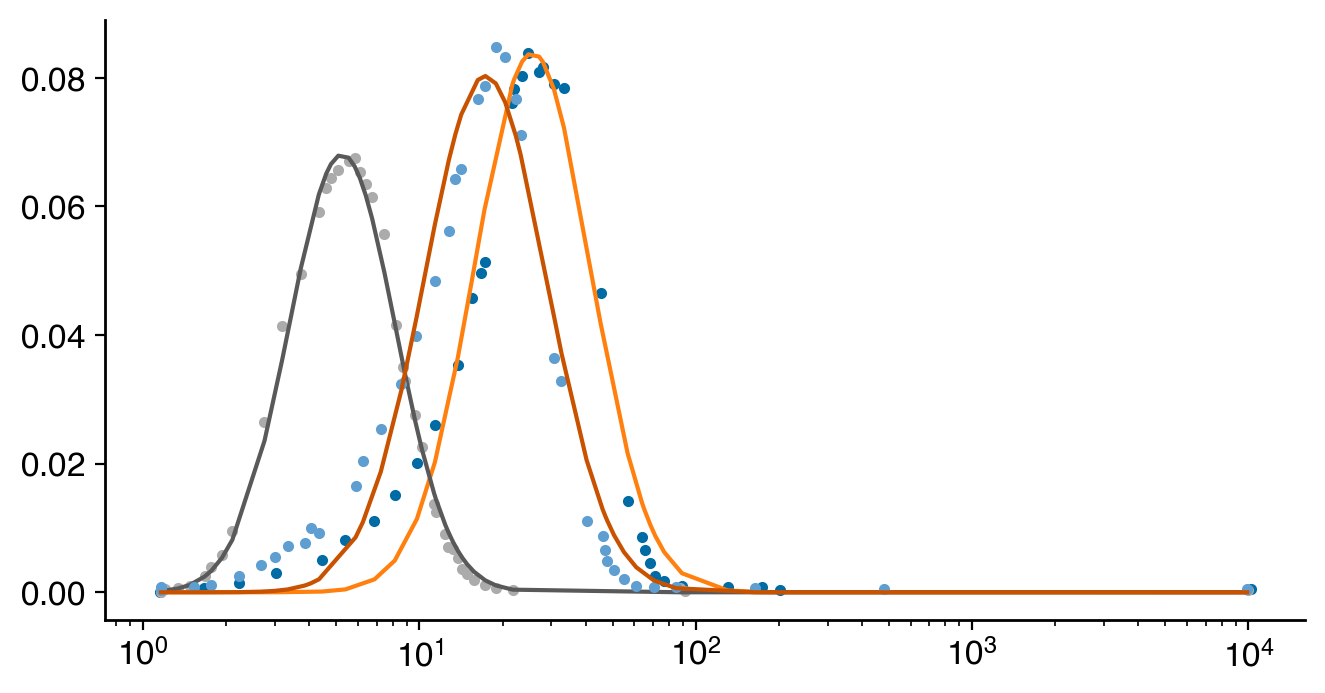

In [11]:
lognorm_pdf = lambda x, mu, sigma: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/trapz(1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2)))
norm_pdf = lambda x, mu, sigma: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))/trapz(1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2)))

results = curve_fit(norm_pdf, np.log(EGF_100['x']), EGF_100[' y']/trapz(EGF_100[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(EGF_100['x'], EGF_100[' y']/trapz(EGF_100[' y']), '.')
ax.plot(EGF_100['x'], norm_pdf(np.log(EGF_100['x']), *results[0])/trapz(norm_pdf(np.log(EGF_100['x']), *results[0])))

results = curve_fit(norm_pdf, np.log(EGF_0_001['x']), EGF_0_001[' y']/trapz(EGF_0_001[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
ax.plot(EGF_0_001['x'], EGF_0_001[' y']/trapz(EGF_0_001[' y']), '.')
ax.plot(EGF_0_001['x'], norm_pdf(np.log(EGF_0_001['x']), *results[0])/trapz(norm_pdf(np.log(EGF_0_001['x']), *results[0])))

results = curve_fit(norm_pdf, np.log(EGF_5['x']), EGF_5[' y']/trapz(EGF_5[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
ax.plot(EGF_5['x'], EGF_5[' y']/trapz(EGF_5[' y']), '.')
ax.plot(EGF_5['x'], norm_pdf(np.log(EGF_5['x']), *results[0])/trapz(norm_pdf(np.log(EGF_5['x']), *results[0])))
ax.set_xscale('log')


In [12]:
lognorm_pdf = lambda x, mu, sigma: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/trapz(1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2)))

results_0 = curve_fit(lognorm_pdf, EGF_0['x'], EGF_0[' y']/trapz(EGF_0[' y']), p0=[2.5, 1], maxfev=10000)
var_0 = lognorm(s=results_0[0][1], scale=np.exp(results_0[0][0])).var()
results_0_001 = curve_fit(lognorm_pdf, EGF_0_001['x'], EGF_0_001[' y']/trapz(EGF_0_001[' y']), p0=[2.5, 1], maxfev=10000)
var_0_001 = lognorm(s=results_0_001[0][1], scale=np.exp(results_0_001[0][0])).var()
results_0_01 = curve_fit(lognorm_pdf, EGF_0_01['x'], EGF_0_01[' y']/trapz(EGF_0_01[' y']), p0=[2.5, 1], maxfev=10000)
var_0_01 = lognorm(s=results_0_01[0][1], scale=np.exp(results_0_01[0][0])).var()
results_0_1 = curve_fit(lognorm_pdf, EGF_0_1['x'], EGF_0_1[' y']/trapz(EGF_0_1[' y']), p0=[2.5, 1], maxfev=10000)
var_0_1 = lognorm(s=results_0_1[0][1], scale=np.exp(results_0_1[0][0])).var()
results_1 = curve_fit(lognorm_pdf, EGF_1['x'], EGF_1[' y']/trapz(EGF_1[' y']), p0=[2.5, 1], maxfev=10000)
var_1 = lognorm(s=results_1[0][1], scale=np.exp(results_1[0][0])).var()
results_3 = curve_fit(lognorm_pdf, EGF_3['x'], EGF_3[' y']/trapz(EGF_3[' y']), p0=[2.5, 1], maxfev=10000)
var_3 = lognorm(s=results_3[0][1], scale=np.exp(results_3[0][0])).var()
results_5 = curve_fit(lognorm_pdf, EGF_5['x'], EGF_5[' y']/trapz(EGF_5[' y']), p0=[2.5, 1], maxfev=10000)
var_5 = lognorm(s=results_5[0][1], scale=np.exp(results_5[0][0])).var()
results_10 = curve_fit(lognorm_pdf, EGF_10['x'], EGF_10[' y']/trapz(EGF_10[' y']), p0=[2.5, 1], maxfev=10000)
var_10 = lognorm(s=results_10[0][1], scale=np.exp(results_10[0][0])).var()
results_30 = curve_fit(lognorm_pdf, EGF_30['x'], EGF_30[' y']/trapz(EGF_30[' y']), p0=[2.5, 1], maxfev=10000)
var_30 = lognorm(s=results_30[0][1], scale=np.exp(results_30[0][0])).var()
results_50 = curve_fit(lognorm_pdf, EGF_50['x'], EGF_50[' y']/trapz(EGF_50[' y']), p0=[2.5, 1], maxfev=10000)
var_50 = lognorm(s=results_50[0][1], scale=np.exp(results_50[0][0])).var()
results_100 = curve_fit(lognorm_pdf, EGF_100['x'], EGF_100[' y']/trapz(EGF_100[' y']), p0=[2.5, 1], maxfev=10000)
var_100 = lognorm(s=results_100[0][1], scale=np.exp(results_100[0][0])).var()

In [13]:
var_0

1.743755288388578

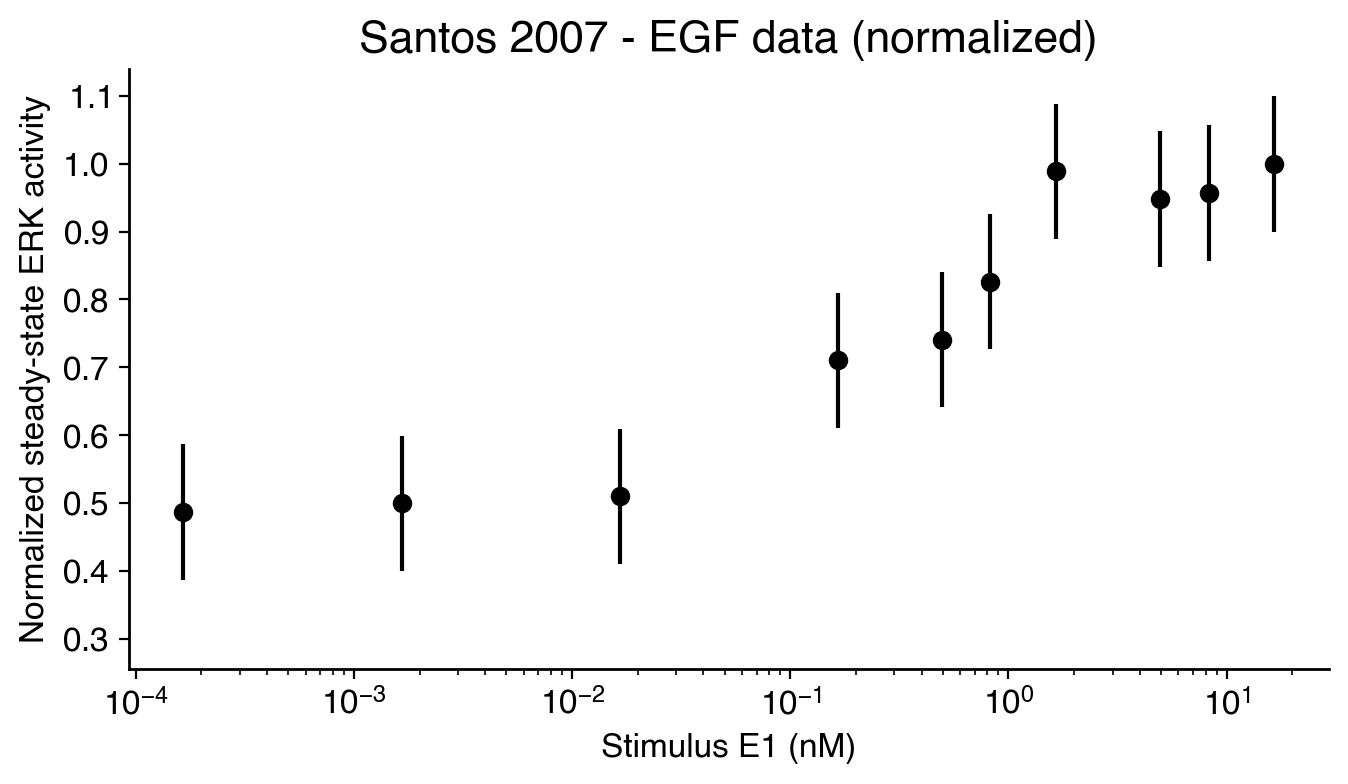

In [15]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ng_ml_nM_convert = 6.048
# errors = np.array([var_0, var_0_001, var_0_01, var_0_1, var_1, var_3, var_5, var_10, var_30, var_50, var_100])
errors = 0.1*np.ones_like(means['EGF (ng/ml)'])
ax.errorbar(means['EGF (ng/ml)']/ng_ml_nM_convert, means['ppERK1/2 (a.u.)']/np.max(means['ppERK1/2 (a.u.)']), yerr=errors, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Normalized steady-state ERK activity')
ax.set_xscale('log')
ax.set_title('Santos 2007 - EGF data (normalized)')
fig.savefig('../../figures/MAPK/Santos_2007_data.pdf', bbox_inches='tight', transparent=True)

In [16]:
normalized_stim_resp = means['ppERK1/2 (a.u.)']/np.max(means['ppERK1/2 (a.u.)'])
stimulus_vals_nM = means['EGF (ng/ml)']/ng_ml_nM_convert

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/Santos_2007_stim_resp_data.csv', index=False)